In [31]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet152

In [32]:
def parse_voc_xml(xml_file, images_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    size_ = root.find('size')
    orig_w = int(size_.find('width').text)
    orig_h = int(size_.find('height').text)
    objects = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        objects.append(dict(
            label=label,
            bbox=[xmin, ymin, xmax, ymax],
            orig_size=(orig_w, orig_h),
            filename=os.path.join(images_dir, filename)
        ))
    return objects

In [33]:
def build_detection_dataframe(annotations_dir, images_dir, label_map=None):
    all_data = []
    for fname in tqdm(os.listdir(annotations_dir)):
        fpath = os.path.join(annotations_dir, fname)
        objects = parse_voc_xml(fpath, images_dir)
        for obj in objects:
            if label_map:
                obj['label_id'] = label_map[obj['label']]
            all_data.append(obj)
    df = pd.DataFrame(all_data)
    return df

In [34]:
label_map = {"cat":0, "dog":1}
inv_label_map = {v:k for k,v in label_map.items()}

In [45]:
df = build_detection_dataframe(
    annotations_dir='../datasets/cat_dog_detection/annotations',
    images_dir='../datasets/cat_dog_detection/images',
    label_map=label_map
)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_id'], random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

img_size = (224,224)
num_classes = len(label_map)
preprocess_fn = tf.keras.applications.resnet.preprocess_input

100%|██████████████████████████████████████████████████████████████████████████████| 3686/3686 [00:07<00:00, 512.90it/s]


In [46]:
def numpy_parse_function(filename, bbox, label_id, orig_size):
    from PIL import Image
    import numpy as np

    if hasattr(filename, 'numpy'):
        filename = filename.numpy()
    if isinstance(filename, bytes):
        filename = filename.decode()

    orig_w, orig_h = orig_size
    orig_w = float(orig_w)
    orig_h = float(orig_h)
    img_size = (224, 224)

    img = Image.open(filename).convert("RGB")
    img = img.resize(img_size)

    sx = img_size[0] / orig_w
    sy = img_size[1] / orig_h

    bbox = np.array(bbox, dtype='float32')
    xmin, ymin, xmax, ymax = bbox

    bbox_scaled = [xmin * sx, ymin * sy, xmax * sx, ymax * sy]
    img_np = np.asarray(img, dtype=np.float32)
    img_np = tf.keras.applications.resnet.preprocess_input(img_np)
    return img_np, np.array(bbox_scaled, dtype=np.float32), label_id

In [47]:
def tf_parse_function(filename, bbox, label_id, orig_size):
    img, bbox_scaled, label_id = tf.py_function(
        numpy_parse_function,
        [filename, bbox, label_id, orig_size],
        [tf.float32, tf.float32, tf.int64]
    )
    img.set_shape((img_size[0], img_size[1], 3))
    bbox_scaled.set_shape((4,))
    label_id.set_shape(())
    y_dict = {'bbox': bbox_scaled, 'class': tf.one_hot(label_id, depth=num_classes)}
    return img, y_dict

In [48]:
def make_detection_dataset(df, batch_size=32, shuffle=True, repeat=False):
    paths = df['filename'].values.astype('str')
    bboxes = np.stack(df['bbox'].values)
    label_ids = df['label_id'].values
    orig_sizes = np.stack(df['orig_size'].values)
    ds = tf.data.Dataset.from_tensor_slices((paths, bboxes, label_ids, orig_sizes))
    ds = ds.map(tf_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    if repeat:
        ds = ds.repeat()
    return ds

In [49]:
batch_size = 16
train_dataset = make_detection_dataset(train_df, batch_size=batch_size, shuffle=True)
val_dataset = make_detection_dataset(val_df, batch_size=batch_size, shuffle=False)

In [50]:
base_model = ResNet152(include_top=False, input_shape=(224,224,3), weights="imagenet")

In [51]:
for l in base_model.layers:
    l.trainable = False

In [52]:
inp = Input(shape=(224,224,3))
features = base_model(inp)
features = GlobalAveragePooling2D()(features)

bbox_output = Dense(128, activation='relu')(features)
bbox_output = Dense(4, activation='linear', name='bbox')(bbox_output)

class_output = Dense(128, activation='relu')(features)
class_output = Dense(num_classes, activation='softmax', name='class')(class_output)

model = keras.Model(inputs=inp, outputs=[bbox_output, class_output])

model.compile(
    optimizer='adam',
    loss={'bbox': 'mse', 'class': 'categorical_crossentropy'},
    metrics={'class':['accuracy']}
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet152           │ (None, 7, 7,      │ 58,370,944 │ input_layer_7[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet152[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox (Dense)        │ (None, 4)         │        516 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class (Dense)       │ (None, 2)         │        258 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,896,262 (224.67 MB)

 Trainable params: 525,318 (2.00 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [53]:
epochs = 5
# STEPS_PER_EPOCH = 125
# VALIDATION_STEPS = 35

In [54]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1
)

Epoch 1/5


I0000 00:00:1772283277.267702    2098 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


185/185 ━━━━━━━━━━━━━━━━━━━━ 140s 296ms/step - bbox_loss: 2098.9534 - class_accuracy: 0.9776 - class_loss: 0.0668 - loss: 2104.1482 - val_bbox_loss: 1135.8080 - val_class_accuracy: 0.9851 - val_class_loss: 0.0554 - val_loss: 1151.9015
Epoch 2/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 55s 168ms/step - bbox_loss: 892.3149 - class_accuracy: 0.9976 - class_loss: 0.0060 - loss: 894.2133 - val_bbox_loss: 802.1220 - val_class_accuracy: 0.9919 - val_class_loss: 0.0278 - val_loss: 810.2183
Epoch 3/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 176ms/step - bbox_loss: 717.9393 - class_accuracy: 0.9976 - class_loss: 0.0052 - loss: 719.0031 - val_bbox_loss: 724.2236 - val_class_accuracy: 0.9864 - val_class_loss: 0.0394 - val_loss: 729.7173
Epoch 4/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 55s 170ms/step - bbox_loss: 641.3184 - class_accuracy: 0.9993 - class_loss: 0.0021 - loss: 641.5774 - val_bbox_loss: 692.8740 - val_class_accuracy: 0.9959 - val_class_loss: 0.0230 - val_loss: 698.6143
Epoch 5/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 53s 17

In [55]:
def deprocess_img(img, preprocess_type="resnet"):
    img = img.copy()
    if preprocess_type == "resnet":
        img[..., 0] += 103.939
        img[..., 1] += 116.779
        img[..., 2] += 123.68
        img = img[..., ::-1]
    elif preprocess_type == "inception":
        img = ((img + 1.0) * 127.5)
    elif preprocess_type == "mobilenet":
        img = ((img + 1.0) * 127.5)
    elif preprocess_type == "none":
        img = img * 255.0
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [56]:
def visualize_od_batch(batch_images, batch_bboxes, batch_labels, class_names, n=8, preprocess_type="resnet"):
    count = min(n, len(batch_images))
    cols = 4
    rows = (count + cols - 1) // cols
    plt.figure(figsize=(4*cols,4*rows))
    for i in range(count):
        img = deprocess_img(batch_images[i].copy(), preprocess_type)
        bbox = batch_bboxes[i]
        label = np.argmax(batch_labels[i]) if batch_labels[i].ndim > 0 else batch_labels[i]
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)
        draw.rectangle(bbox.tolist(), outline='red', width=2)
        draw.text((bbox[0], bbox[1]-10), class_names[label], fill=(255,0,0))
        plt.subplot(rows, cols, i+1)
        plt.imshow(img_pil)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [57]:
def iou(b1, b2):
    xA = max(b1[0], b2[0])
    yA = max(b1[1], b2[1])
    xB = min(b1[2], b2[2])
    yB = min(b1[3], b2[3])
    interArea = max(0, xB-xA+1) * max(0, yB-yA+1)
    boxAArea = (b1[2]-b1[0]+1) * (b1[3]-b1[1]+1)
    boxBArea = (b2[2]-b2[0]+1) * (b2[3]-b2[1]+1)
    return interArea / float(boxAArea + boxBArea - interArea)

In [58]:
def analyze_detection_predictions(
    model, dataset, class_names, preprocess_type="resnet", max_errors=12, max_samples=128
):
    true_imgs, true_bboxes, true_classes, pred_bboxes, pred_classes, ious = [], [], [], [], [], []
    count = 0
    for images, labels in dataset:
        bboxes = labels['bbox'].numpy()
        classes = labels['class'].numpy()
        y_cls = np.argmax(classes, axis=-1)
        preds_bbox, preds_cls = model.predict(images, verbose=0)
        y_pred_cls = np.argmax(preds_cls, axis=-1)
        for i in range(len(images)):
            if count >= max_samples:
                break
            true_imgs.append(images[i].numpy())
            true_bboxes.append(bboxes[i])
            true_classes.append(y_cls[i])
            pred_bboxes.append(preds_bbox[i])
            pred_classes.append(y_pred_cls[i])
            ious.append(iou(bboxes[i], preds_bbox[i]))
            count += 1
        if count >= max_samples:
            break
    errors = []
    for idx, (tcls, pcls, tiou) in enumerate(zip(true_classes, pred_classes, ious)):
        if tcls != pcls or tiou < 0.5:
            errors.append(idx)
    n_plot = min(max_errors, len(errors))
    if n_plot == 0:
        print('No errors in the selected subset')
        return
    cols = 4
    rows = (n_plot + cols - 1) // cols
    plt.figure(figsize=(4*cols,4*rows))
    for i, idx in enumerate(errors[:n_plot]):
        img = deprocess_img(true_imgs[idx].copy(), preprocess_type)
        true_bbox = true_bboxes[idx]
        pred_bbox = pred_bboxes[idx]
        tcls = true_classes[idx]
        pcls = pred_classes[idx]
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)
        draw.rectangle(true_bbox.tolist(), outline='green', width=2)
        draw.rectangle(pred_bbox.tolist(), outline='red', width=2)
        draw.text((true_bbox[0], true_bbox[1]-15), 'T:'+class_names[tcls], fill=(0,255,0))
        draw.text((pred_bbox[0], pred_bbox[1]-5), 'P:'+class_names[pcls], fill=(255,0,0))
        plt.subplot(rows, cols, i+1)
        plt.imshow(img_pil)
        plt.title(f'IoU: {ious[idx]:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

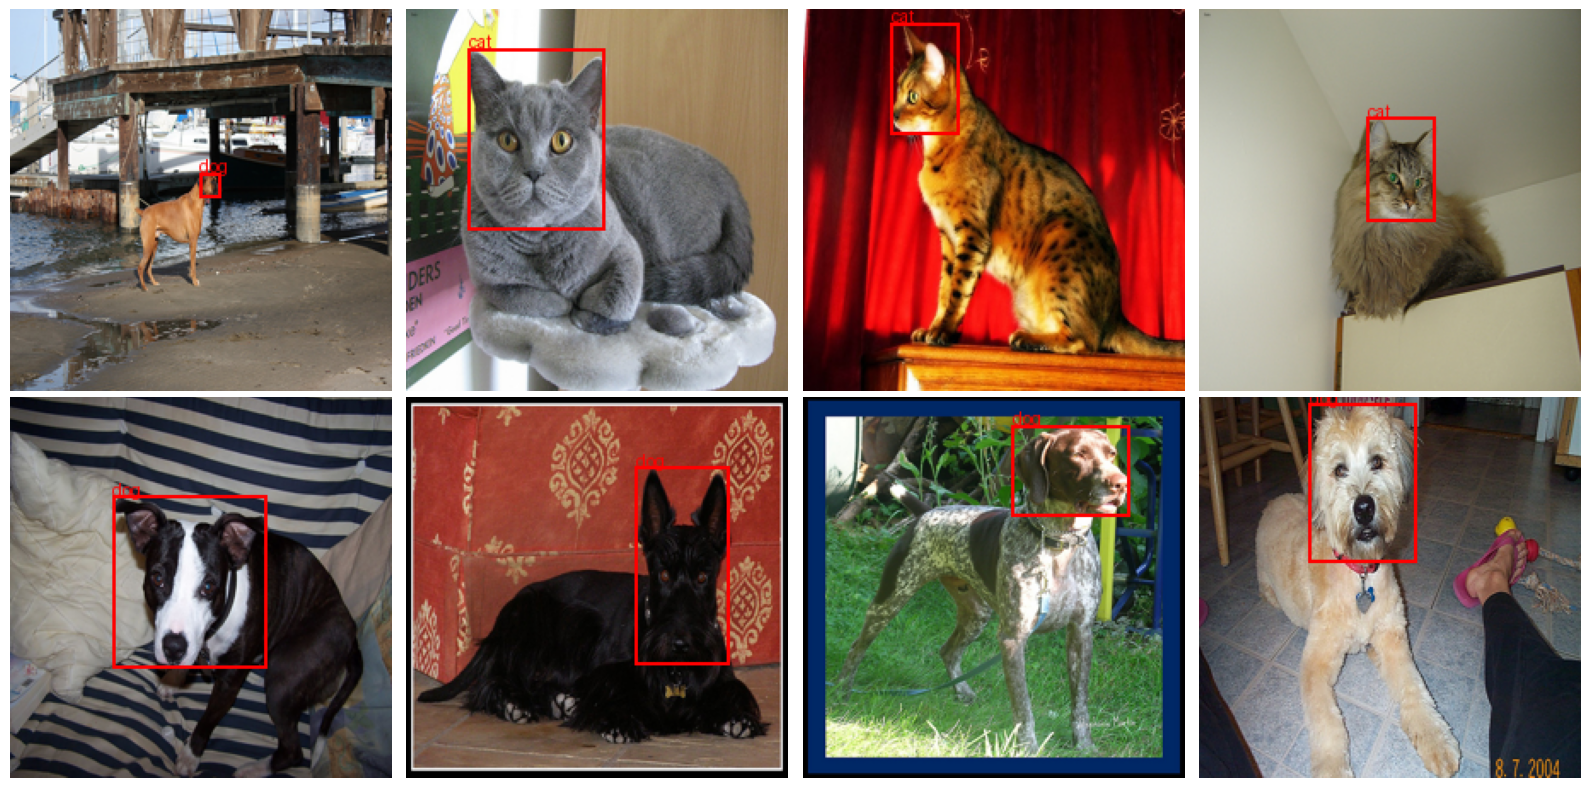

In [59]:
batch = next(iter(val_dataset))
visualize_od_batch(
    batch[0].numpy(),
    batch[1]['bbox'].numpy(),
    batch[1]['class'].numpy(),
    class_names=list(inv_label_map.values()),
    n=8,
    preprocess_type="resnet"
)

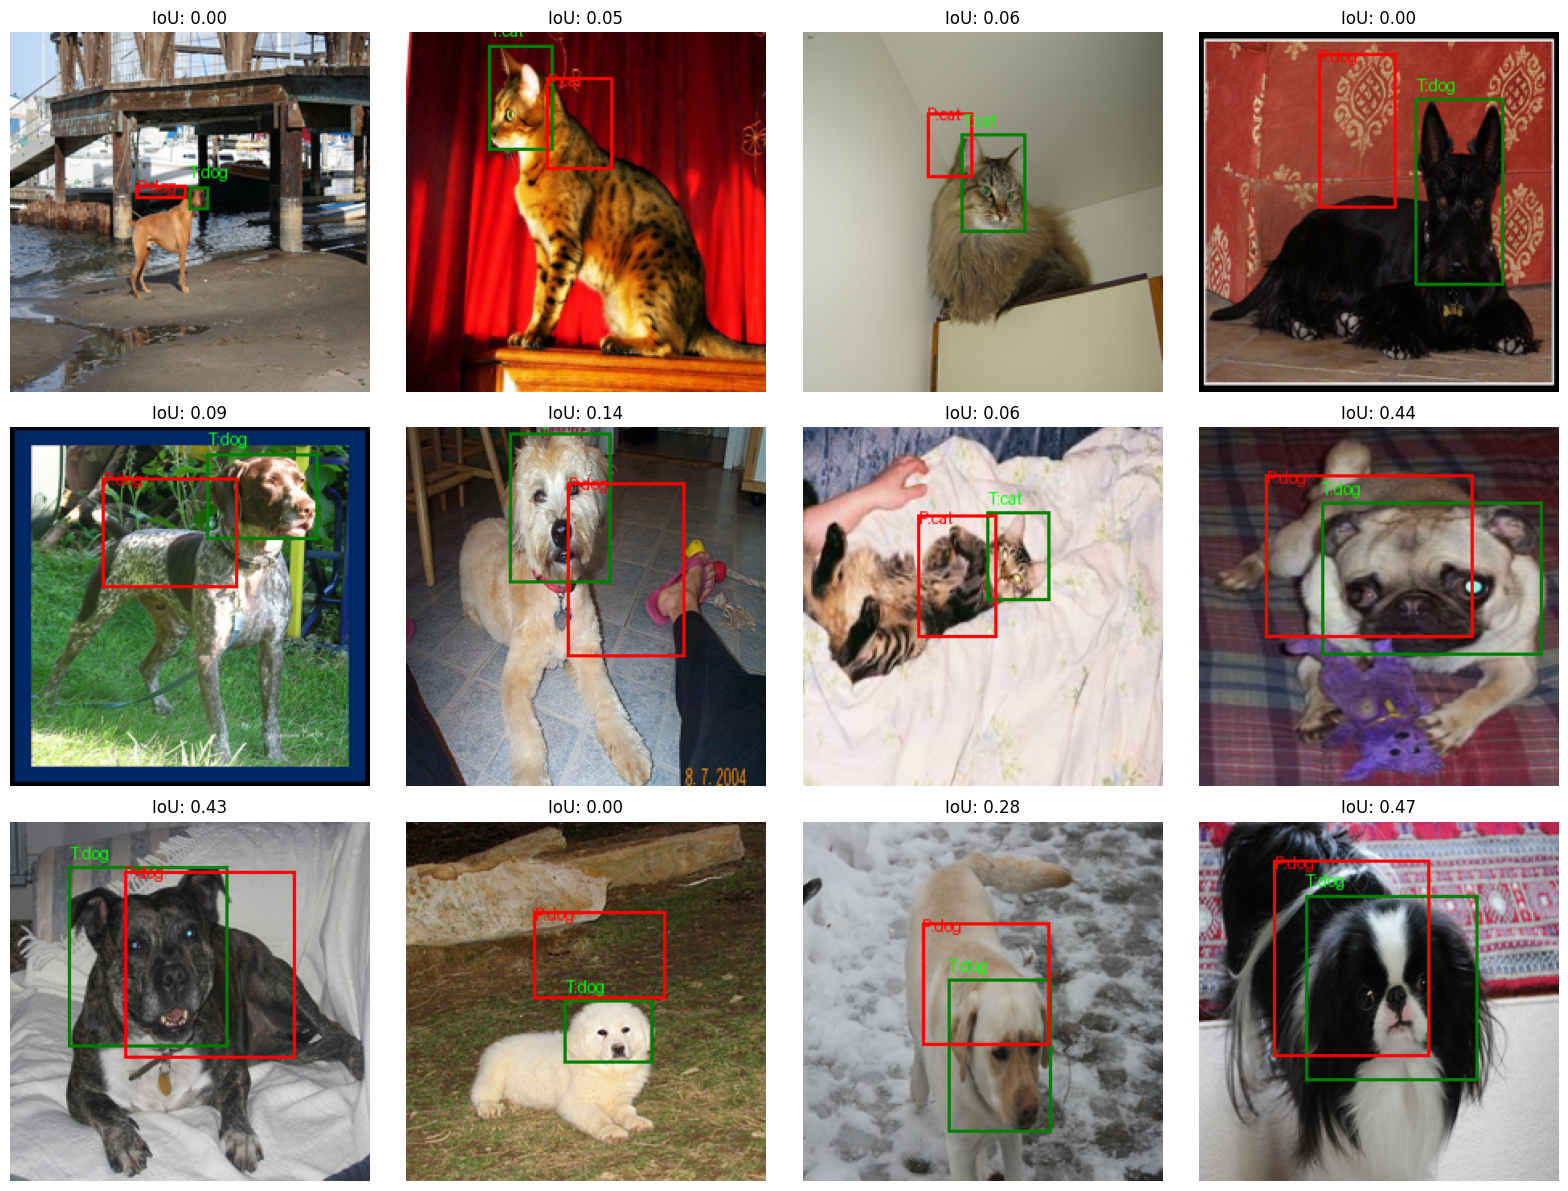

In [60]:
analyze_detection_predictions(
    model, val_dataset, class_names=list(inv_label_map.values()), preprocess_type="resnet", max_errors=12, max_samples=128
)